# Check_for_statistical_difference_in_slope_loop.ipynb

This code uses the NDVI slope data produced from Palaeovalley_NDVI_linear_regression.py to check for statistical difference within and outside of mapped palaeovalleys. This code is based upon NDVI_wetdry_stats_plot.ipynb, but has been modified to only include one input dataset, instead of two. This code should be able to be modified for different input datasets in the future. 

Written by Claire Krause, January 2017, Datacube v 1.13, Python v3

** Code dependencies **
- csv file containing the bounding boxes for the case study site/s
- palaeovalleys 2012 shape file
- *NDVI_slope.nc from /g/ data for each of the study sites

**Accompanying code**
- Check_for_statistical_difference_in_slope.ipynb - this code demonstrates the calculation of significance statistics for one example site. See this code for a more thorough discussion of what this looped code does.

In [1]:
# Import the libraries we need in the code and tell matplotlib to display the plots here
%matplotlib inline
import fiona
import shapely.geometry
import rasterio
import rasterio.features
import geopandas as gp
import datacube
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats
import pandas
import csv
import os

In [2]:
# Set up some functions to use later in the code
def warp_geometry(geom, src_crs, dst_crs):
    """
    warp geometry from src_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(src_crs, dst_crs, shapely.geometry.mapping(geom)))

def geometry_mask(geom, geobox, all_touched=False, invert=False):
    """
    rasterize geometry into a binary mask where pixels that overlap geometry are False
    """
    return rasterio.features.geometry_mask([geom],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)
def write_to_csv(OUTPUT_path, row):
    if Studysite.Name == 'Blackwood2A':
        with open(OUTPUT_path,'w') as csvFile:
            writer = csv.writer(csvFile)
            header = ['name', 'ttest', 'KS_test']
            writer.writerow(header)
            writer.writerow(row)
    else:
        with open(OUTPUT_path,'a') as csvFile:
           writer = csv.writer(csvFile)
           writer.writerow(row)

## Load in our list of sites

In [3]:
# Set up the case study bounding box (to make the file smaller and avoid memory errors)
# Read in a csv file with all case study bounding boxes
names = pandas.read_csv('/g/data/p25/cek156/case_study_sites_small.csv', delimiter = ',')
print(names)

           Name     minlat     maxlat      minlon      maxlon
0   Blackwood2A -34.100000 -33.400000  116.400000  117.400000
1   Blackwood2B -34.100000 -33.400000  117.400000  118.400000
2   Blackwood2C -33.400000 -32.700000  116.400000  117.400000
3   Blackwood2D -33.400000 -32.700000  117.400000  118.400000
4      GarfordA -29.900000 -29.230000  133.150000  133.925000
5      GarfordB -29.900000 -29.230000  133.925000  134.700000
6     Mandora1A -21.100000 -20.356667  120.900000  121.916667
7     Mandora1B -21.100000 -20.356667  121.916667  122.933333
8     Mandora1C -21.100000 -20.356667  122.933333  123.950000
9     Mandora1D -21.100000 -20.356667  123.950000  124.966667
10    Mandora1E -21.100000 -20.356667  124.966667  125.983333
11    Mandora1F -21.100000 -20.356667  125.983333  127.000000
12    Mandora1G -20.356667 -19.613333  120.900000  121.916667
13    Mandora1H -20.356667 -19.613333  121.916667  122.933333
14    Mandora1I -20.356667 -19.613333  122.933333  123.950000
15    Ma

## Set up the palaeovalley 2012 mask. 
This code reads in the shapefile and identifies and lists all of the polygons witin it. For this example, we are using the 2012 Palaeovalleys shape file (see English et al. 2012)

In [4]:
shp = gp.GeoDataFrame.from_file('/g/data/p25/cek156/Palaeovalleys_2012.shp')
print (shp.head)

<bound method NDFrame.head of                                               geometry
0    POLYGON ((123.648953793 -30.56992565499991, 12...
1    (POLYGON ((117.1778376770001 -32.2709919609999...
2    POLYGON ((115.868565061 -29.73637336599995, 11...
3    POLYGON ((115.948200584 -27.86854227199996, 11...
4    POLYGON ((127.387641593 -28.59592641999996, 12...
5    POLYGON ((128.0569520910001 -28.54635345199995...
6    POLYGON ((128.698006552 -26.21770164599991, 12...
7    POLYGON ((126.722619924 -22.32913755999994, 12...
8    POLYGON ((128.3006654730001 -18.96357787199992...
9    POLYGON ((115.3584853260001 -27.20097888599992...
10   POLYGON ((126.9556900690001 -26.30121716599996...
11   POLYGON ((115.8733712540001 -25.14138591099993...
12   POLYGON ((125.9475394960001 -28.62771558199995...
13   POLYGON ((124.9745967660001 -29.53551659999994...
14   POLYGON ((120.9398331570001 -19.64230130599992...
15   POLYGON ((128.361469574 -22.02882464999993, 12...
16   POLYGON ((123.9446491120001 -3

## Calculate the statistics for each site

Loop through each case study site, apply the palaeovalleys 2012 mask, calculate the statistical difference in values inside and outside the masked areas, then write the results to a csv file

In [5]:
# Set up the paths to the output file
OUTPUT = '/g/data/p25/cek156/NDVI/NDVI_slope_JulDec.csv'

# Work out how many sites we want to analyse, and set up a list of numbers we can loop through
x = len(names.index)
iterable = list(range(0,x-6)) 
# NB -6 because we don't have pv polygons for Daintree, Laura or Blackwood1, and we don't want to run the testing site

for num in iterable:
    Studysite = names.ix[num]
    print ('Working on ' + Studysite.Name)
    # Create a bounding box from the locations specified above
    box = shapely.geometry.box(names.minlon[num], names.minlat[num], names.maxlon[num], names.maxlat[num], ccw = True)
    # Only get the polygons that intersect the bounding box (i.e. remove all the irrelevant ones)
    filtered = shp.where(shp.intersects(box)).dropna()
    # Combine all of the relevant polygons into a single polygon
    shp_union = shapely.ops.unary_union(filtered.geometry)
    
    # Read in the data to apply the stats to
    slope_output_name = '/g/data/p25/cek156/NDVI/' + Studysite.Name + '/' + Studysite.Name + '_NDVI_slope_JulDec.nc'
    file_check1 = os.path.isfile(slope_output_name)
    if file_check1:
        data = xr.open_dataset(slope_output_name)
        # Check for the geobox attribute. If it's not there, apply it from the datacube.
        if not hasattr(data, 'geobox'):
            query = {'time': ('2000-01-01', '2000-01-31'),
                     'lat': (names.maxlat[num], names.minlat[num]), 
                     'lon': (names.minlon[num], names.maxlon[num]), 
                     'resolution': (-250, 250)}
            bands_of_interest = [#'blue',
                                 #'green',
                                 'red', 
                                 #'nir',
                                 #'swir1', 
                                 #'swir2',
                                 ]
            dc = datacube.Datacube(app='hack')
            nbar = dc.load(product = 'ls7_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
            print('Applying datacube geobox')
            geobox = nbar.geobox
            data.attrs['geobox'] = geobox
        # Create the mask based on our shapefile
        mask = geometry_mask(warp_geometry(shp_union, shp.crs, data.crs), data.geobox, invert=True)
        # Get data only where the mask is 'true'
        data_masked = data.where(mask)
        # Get data only where the mask is 'false'
        data_maskedF = data.where(~ mask)
                
        ## Now check for statistical significance
        # Create a new numpy array with just the slope values
        data_masked2 = np.array(data_masked.slope)
        data_maskedF2 = np.array(data_maskedF.slope)
        # Remove nan values
        data_masked_nonan = data_masked2[~np.isnan(data_masked2)]
        data_maskedF_nonan = data_maskedF2[~np.isnan(data_maskedF2)]
        masked_both = [data_masked_nonan,data_maskedF_nonan]
        if data_masked_nonan.any():
            # How many data points are in each of my NDVI lists?
            size = ([len(i) for i in masked_both])
            # Test with a t-test
            stats_ttest, ttest_pval = scipy.stats.ttest_ind(data_masked_nonan,data_maskedF_nonan, equal_var = 'False')
            # Test with a Kolmogorov-Smirnov test 
            # Our null hypothesis that 2 independent samples are drawn from the same continuous distribution
            stats_KS, KS_pval = scipy.stats.ks_2samp(data_masked_nonan,data_maskedF_nonan)

            # Write to csv file
            row = [Studysite.Name, stats_ttest, stats_KS]
            # Write our stats to a csv file so we can compare them later
            # If this is the first site, make a new file, otherwise, append the existing file
            print('writing to csv')
            write_to_csv(OUTPUT, row)
            # Or if there is no data...
        else:
            print('no useful slope data')
            row = [Studysite.Name, 'nan', 'nan']
            write_to_csv(OUTPUT, row)
    # Or if there is no data...
    else:
        print('writing no data to csv')
        row = [Studysite.Name, 'nan', 'nan']
        write_to_csv(OUTPUT, row)

Working on Blackwood2A
Applying datacube geobox
writing to csv
Working on Blackwood2B
Applying datacube geobox
writing to csv
Working on Blackwood2C
Applying datacube geobox
writing to csv
Working on Blackwood2D
Applying datacube geobox
writing to csv
Working on GarfordA
Applying datacube geobox
writing to csv
Working on GarfordB
Applying datacube geobox
no useful slope data
Working on Mandora1A
Applying datacube geobox
writing to csv
Working on Mandora1B
Applying datacube geobox
writing to csv
Working on Mandora1C
Applying datacube geobox
writing to csv
Working on Mandora1D
Applying datacube geobox
writing to csv
Working on Mandora1E
Applying datacube geobox
writing to csv
Working on Mandora1F
Applying datacube geobox
writing to csv
Working on Mandora1G
Applying datacube geobox
writing to csv
Working on Mandora1H
Applying datacube geobox
writing to csv
Working on Mandora1I
Applying datacube geobox
writing to csv
Working on Mandora1J
Applying datacube geobox
writing to csv
Working on M

## Read in the csv file and prepare for plotting

At this stage, the smaller chunks of each case study area still have their own statistics. We want to know what the solution is over the whole bounding box, so we will average the stats together here to give us just one output for each site.

In [6]:
study_sites = pandas.read_csv('/g/data/p25/cek156/case_study_sites.csv')
numsites = len(study_sites)

#Read in the CSV with the slope stats
slope_stats = pandas.read_csv(OUTPUT)

mean_values = pandas.DataFrame(columns = ['Site', 'ttest_mean', 'KS_mean'])

exclude_last_three = study_sites[:-3]
for idx, site in enumerate(exclude_last_three.Name):
    ttest_mean = slope_stats[slope_stats.name.str.contains(site)].ttest.mean()
    ks_mean = slope_stats[slope_stats.name.str.contains(site)].KS_test.mean()
    mean_values.loc[idx] = [site, ttest_mean, ks_mean]

print(mean_values)

         Site  ttest_mean   KS_mean
0  Blackwood2   24.498278  0.167094
1     Garford  -37.796911  0.154177
2    Mandora1   37.692463  0.188550
3    Mandora2   57.487513  0.246522
4   Murchison   16.497770  0.129208
5         Ord  -32.356815  0.213130
6      TiTree   -1.323832  0.130803


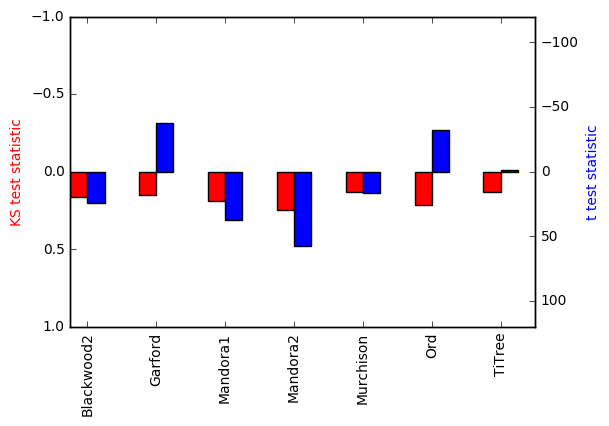

In [7]:
# Setting the positions and width for the bars
pos = list(range(len(mean_values.ttest_mean)))
width = 0.25

# Plotting the bars
#fig, ax = plt.subplots(figsize=(10,5))

fig = plt.figure()

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

#plt.bar(pos, mean_values['KS_mean'], width, color = 'g')
#plt.bar([p + width for p in pos], mean_values['ttest_mean'], width, color = 'r')
mean_values.KS_mean.plot(kind='bar', color='red', ax=ax, width=width, position=1)
mean_values.ttest_mean.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

# Set the y axis label
ax.set_ylabel('KS test statistic', color='red')
ax2.set_ylabel('t test statistic', color='blue')

# Set the position of the x ticks
#ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(mean_values['Site'])

# Setting the x-axis and y-axis limits

ax2.set_ylim([120, -120])
ax.set_ylim([1, -1])

#Let's save the plot
fig.savefig('/g/data/p25/cek156/NDVI/NDVI_slope_stats_JulDec.jpg', bbox_inches='tight')